<a href="https://colab.research.google.com/github/yashc73080/CS462-Deep-Learning/blob/main/HW3/sequences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from tqdm.auto import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

Using device: cuda


# 1. Change Point Detection

## Data Generation

$t = 0 → s(0) = [x_{00}, x_{01}, ..., x_{09}] \\
t = 1 → s(1) = [x_{10}, x_{11}, ..., x_{19}] \\
t = 2 → s(2) = [x_{20}, x_{21}, ..., x_{29}] \\
\cdots \\
t = 99 → s(99)$

In [4]:
def generate_sequence(max_T=100):
    length = max_T

    # Decide change point including "no change"
    T = random.randint(0, length)

    # Create the full sequence of shape (length, 10)
    seq = torch.randn(length, 10)

    # Pick 5 indices out of 10
    indices = random.sample(range(10), 5)

    # Create means for these indices
    mus = {idx: random.uniform(-1, 1) for idx in indices}

    # Apply shift only after change point
    if T < length:
        for idx in indices:
            seq[T:, idx] += mus[idx]

    # Label: 0 if no change happened yet, 1 if change occurred
    label = 1 if T < length else 0

    return seq, label, T


In [5]:
class ChangePointDataset(Dataset):
    def __init__(self, num_sequences, device='cpu'):
        self.num_sequences = num_sequences
        self.device = device

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        seq, label, T = generate_sequence()
        seq = seq.to(self.device)
        labels = torch.zeros(seq.shape[0], 1, device=self.device)
        labels[T:] = 1
        return seq, labels, T

Get dataset

In [6]:
dataset = ChangePointDataset(15000, device=device)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

## RNN and LSTM model definitions

In [7]:
class RNNModel(nn.Module):
    def __init__(self, input_size=10, hidden_size=20, output_size=1, num_layers=1,device='cpu'):
        super(RNNModel, self).__init__()

        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, bias=True,
                          dropout=0, bidirectional=False, batch_first=True)

        self.fc = nn.Linear(hidden_size, output_size)

        self.to(device)

    def forward(self, x):
        # input x: (batch_size, time, features)
        out, _ = self.rnn(x) # out: (batch_size, time, hidden_size)
        logits = self.fc(out) # logits: (batch_size, time, 1)
        probability = torch.sigmoid(logits) # probability: (batch_size, time, 1)

        return probability

In [8]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=10, hidden_size=20, output_size=1, num_layers=1, device='cpu'):
        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            bias=True, dropout=0.3, batch_first=True)

        self.layer_norm = nn.LayerNorm(hidden_size)

        self.fc = nn.Linear(hidden_size, output_size)

        self.to(device)

    def forward(self, x):
        # input x: (batch_size, time, features)
        out, _ = self.lstm(x) # out: (batch_size, time, hidden_size)

        out = self.layer_norm(out)

        logits = self.fc(out) # logits: (batch_size, time, 1)
        probability = torch.sigmoid(logits) # probability: (batch_size, time, 1)

        return probability

In [ ]:
def train_model(model, dataloader, num_epochs=10, lr=0.01, plot=False):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()

    loss_history = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for sequences, labels, T_values in dataloader:
            optimizer.zero_grad()

            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * sequences.size(0)

        epoch_loss /= len(dataloader.dataset)
        loss_history.append(epoch_loss)

        if epoch % 5 == 0 or epoch == num_epochs - 1:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    if plot:
        plt.plot(loss_history)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss History')
        plt.show()

    return model, loss_history

In [10]:
def get_probabilities(model, seq):
    model.eval()
    with torch.no_grad():
        seq = seq.unsqueeze(0)          # (1, 100, 10)
        prob = model(seq).squeeze()     # (100,)
    return prob

def plot_probabilities(probabilities, T):
    # Create x-axis relative to T
    time_steps = np.arange(len(probabilities))
    relative_time = time_steps - T

    plt.figure(figsize=(10, 4))
    plt.plot(relative_time, probabilities.cpu().numpy(), label='Predicted Probability')
    plt.axvline(x=0, color='green', linestyle='-', label='Change Point (T)')

    plt.xlabel('Time Relative to Change Point (t - T)')
    plt.ylabel('Probability')
    plt.title(f'Detection Probability (Change Point at T={T})')
    plt.legend()
    plt.grid()
    plt.show()

def evaluate_and_plot_aggregate(model, dataloader, device):
    model.eval()

    # Dictionary to store probabilities for each relative time step (t - T)
    # Key: relative_time, Value: list of probabilities
    rel_probs = {}

    with torch.no_grad():
        for seq, _, T_val in dataloader:
            seq = seq.to(device)
            probs = model(seq).squeeze(-1).cpu().numpy() # (batch, time)
            T_val = T_val.numpy()

            for i in range(seq.shape[0]): # Loop over batch
                T = T_val[i]
                length = seq.shape[1]

                # Only consider sequences where a change actually occurred within the window
                if T < length:
                    for t in range(length):
                        rel_t = t - T
                        if rel_t not in rel_probs:
                            rel_probs[rel_t] = []
                        rel_probs[rel_t].append(probs[i, t])

    # Calculate averages
    x_vals = sorted(rel_probs.keys())
    y_vals = [np.mean(rel_probs[x]) for x in x_vals]

    # Get a window
    plot_x = []
    plot_y = []
    for x, y in zip(x_vals, y_vals):
        if -50 <= x <= 50:
            plot_x.append(x)
            plot_y.append(y)

    plt.figure(figsize=(10, 5))
    plt.plot(plot_x, plot_y, marker='o')
    plt.axvline(0, color='r', linestyle='--', label='Change Point')
    plt.xlabel('Distance from Change Point (t - T)')
    plt.ylabel('Average Detection Probability')
    plt.title('Average Detection Probability vs. Time')
    plt.grid(True)
    plt.legend()
    plt.show()

## Testing RNN

Epoch 1/50, Loss: 0.6981
Epoch 6/50, Loss: 0.5382
Epoch 11/50, Loss: 0.4529
Epoch 16/50, Loss: 0.4288
Epoch 21/50, Loss: 0.4010
Epoch 26/50, Loss: 0.4004
Epoch 31/50, Loss: 0.3889
Epoch 36/50, Loss: 0.3849
Epoch 41/50, Loss: 0.3708
Epoch 46/50, Loss: 0.3709
Epoch 50/50, Loss: 0.3744


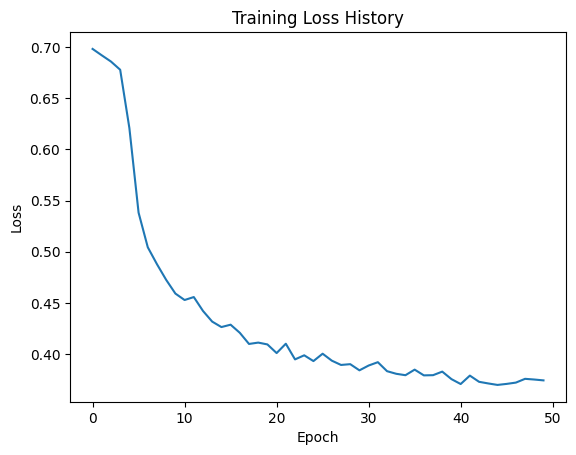

In [ ]:
rnn = RNNModel(input_size=10, hidden_size=20, output_size=1, device=device)
rnn, loss_history = train_model(rnn, dataloader, num_epochs=50, lr=0.001, plot=True)

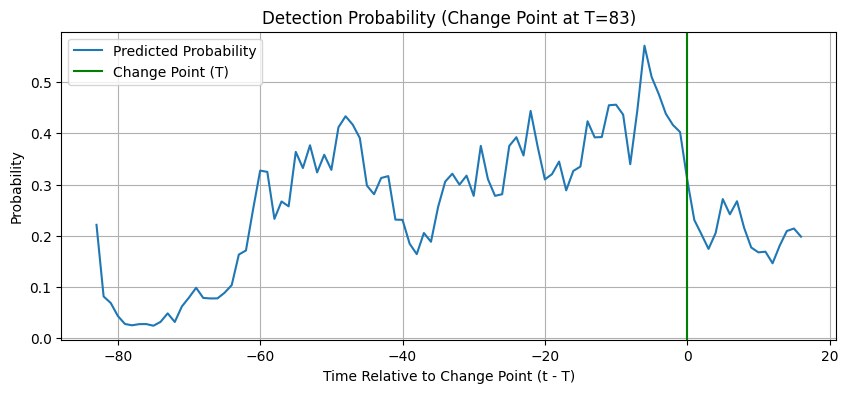

In [ ]:
seq, label, T = dataloader.dataset[0]
probabilities = get_probabilities(rnn, seq)
plot_probabilities(probabilities, T)

## Testing LSTM

Epoch 1/70, Loss: 0.4691
Epoch 6/70, Loss: 0.2676
Epoch 11/70, Loss: 0.2662
Epoch 16/70, Loss: 0.2567
Epoch 21/70, Loss: 0.2547
Epoch 26/70, Loss: 0.2510
Epoch 31/70, Loss: 0.2519
Epoch 36/70, Loss: 0.2532
Epoch 41/70, Loss: 0.2525
Epoch 46/70, Loss: 0.2494
Epoch 51/70, Loss: 0.2480
Epoch 56/70, Loss: 0.2468
Epoch 61/70, Loss: 0.2500
Epoch 66/70, Loss: 0.2480
Epoch 70/70, Loss: 0.2461


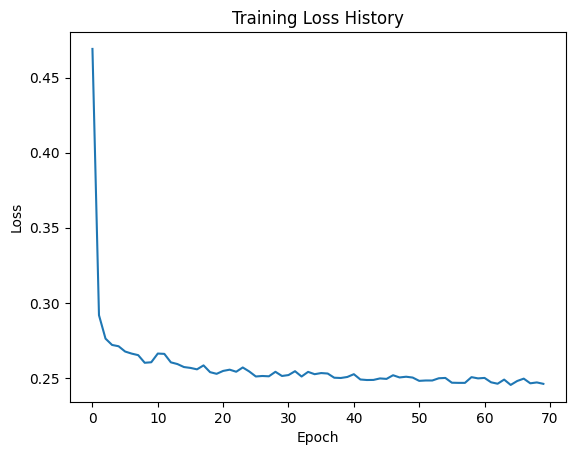

In [73]:
lstm = LSTMModel(input_size=10, hidden_size=256, output_size=1, num_layers=2, device=device)
lstm, lstm_loss_history = train_model(lstm, dataloader, num_epochs=70, lr=0.001, plot=True)

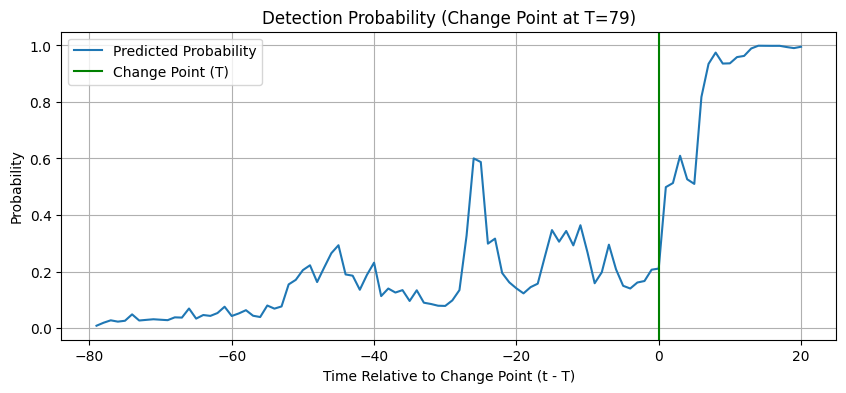

In [ ]:
seq, label, T = dataloader.dataset[0]
probabilities = get_probabilities(lstm, seq)
plot_probabilities(probabilities, T)

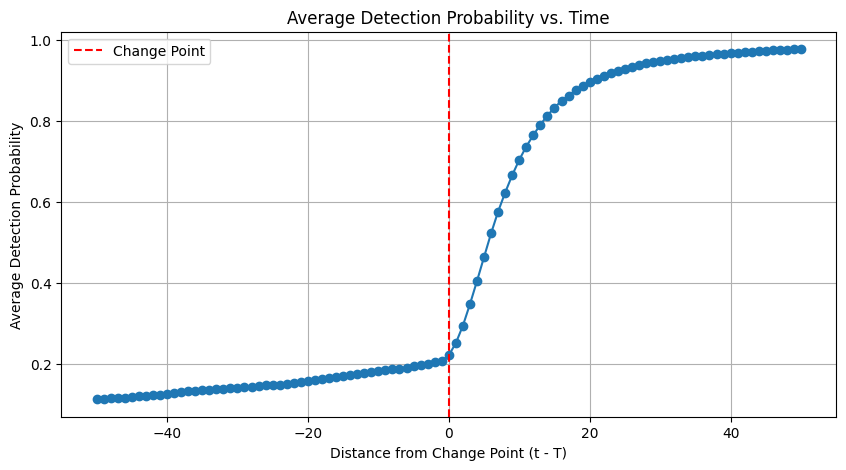

In [ ]:
evaluate_and_plot_aggregate(lstm, dataloader, device)

## 1-D CNN model

In [45]:
class CNNModel(nn.Module):
  def __init__(self, in_channels=10, out_dim=1, kernel=3, stride=1, sequence_length=100, device='cpu'):
    super(CNNModel, self).__init__()

    padding = kernel // 2 # for not having enough terms early on in conv window

    # Convolutional Layers
    self.conv_layers = nn.Sequential(
        nn.Conv1d(in_channels, 64, kernel_size=kernel, stride=stride, padding=padding),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Conv1d(64, 64, kernel_size=kernel, stride=stride, padding=padding),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Conv1d(64, 64, kernel_size=kernel, stride=stride, padding=padding),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        # Final layer to map it down to 1 dimension
        nn.Conv1d(64, out_dim, kernel_size=1)
      )

    self.to(device)

  def forward(self, x):
    # x is (batch, time=100, features=10)
    # we want (batch, features, time)
    x = x.permute(0,2,1)

    x = self.conv_layers(x)

    # want (batch, time, out_dim=1) to compare with labels
    probabilities = torch.sigmoid(x.permute(0,2,1))

    return probabilities

## Testing CNN

Epoch 1/50, Loss: 0.3488
Epoch 6/50, Loss: 0.2329
Epoch 11/50, Loss: 0.2272
Epoch 16/50, Loss: 0.2180
Epoch 21/50, Loss: 0.2166
Epoch 26/50, Loss: 0.2096
Epoch 31/50, Loss: 0.2124
Epoch 36/50, Loss: 0.2104
Epoch 41/50, Loss: 0.2115
Epoch 46/50, Loss: 0.2087
Epoch 50/50, Loss: 0.2071


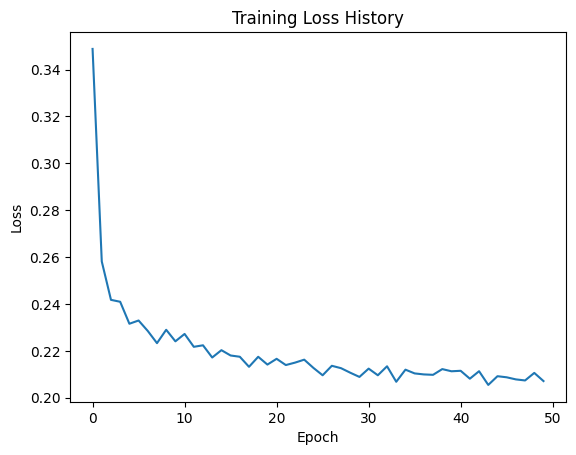

In [46]:
cnn = CNNModel(in_channels=10, out_dim=1, kernel=7, stride=1, sequence_length=100, device=device)
cnn, cnn_loss_history = train_model(cnn, dataloader, num_epochs=50, lr=0.001, plot=True)

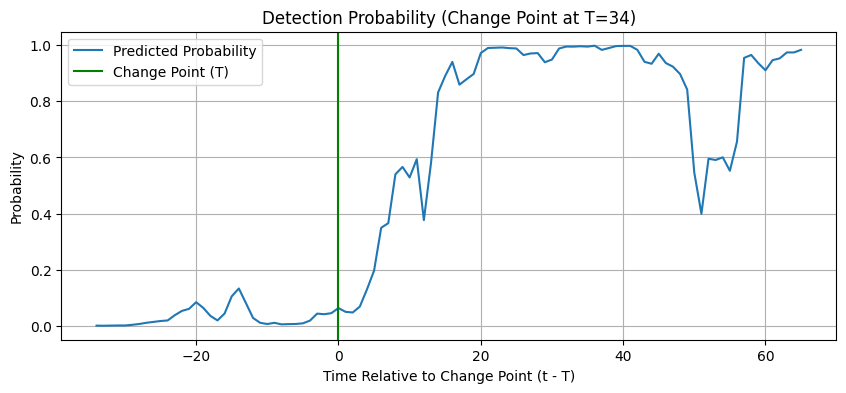

In [78]:
seq, label, T = dataloader.dataset[0]
probabilities = get_probabilities(cnn, seq)
plot_probabilities(probabilities, T)

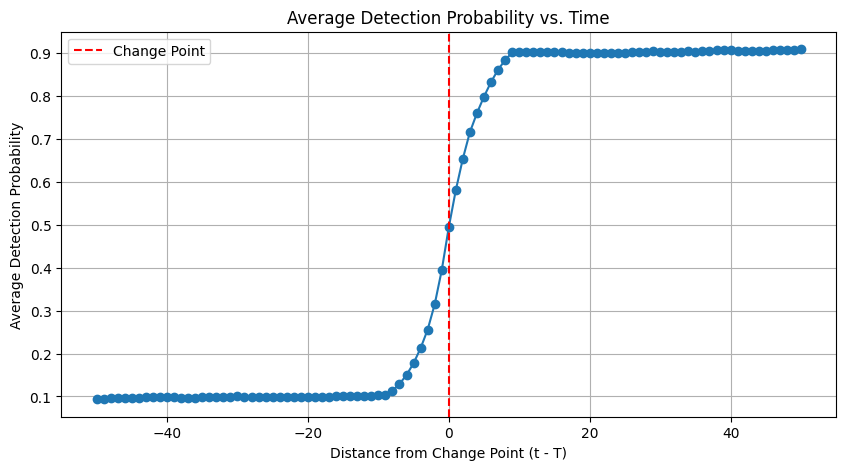

In [79]:
evaluate_and_plot_aggregate(cnn, dataloader, device)

# 2. Summarization

## Classic Non-AI Approach

In [20]:
def classic_summarize(seq):
    res = [False] * 10
    for i in seq:
        res[i] = True

    return res

def classic_query(summary, q):
    return summary[q]

In [21]:
seq = [3,1,5,6,3,6,8,3]
summary = classic_summarize(seq)

print("Summary:", summary)
print("Query for 3:", classic_query(summary, 3)) 
print("Query for 7:", classic_query(summary, 7))

Summary: [False, True, False, True, False, True, True, False, True, False]
Query for 3: True
Query for 7: False


## Dataset

In [9]:
class SummaryQueryDataset(Dataset):
    def __init__(self, num_sequences, device='cpu'):
        self.num_sequences = num_sequences
        self.device = device

    def __len__(self):
        return self.num_sequences
    
    def __getitem__(self, idx):
        while True:
            length = random.randint(5, 200)
            seq = [random.randint(0, 9) for _ in range(length)]

            if random.random() < 0.5:
                # Query is in sequence
                q = random.choice(seq)
            else:
                # Query not in sequence
                digit_to_remove = random.choice(seq)
                seq = [x for x in seq if x != digit_to_remove]
                q = digit_to_remove
                length = len(seq) 

            if len(seq) > 0:
                label = 1 if q in seq else 0
                return seq, q, label
    
PADDING_TOKEN = 10

def collate_padding(batch):
    sequences = [item[0] for item in batch]
    queries = [item[1] for item in batch]
    labels = [item[2] for item in batch]

    lengths = [len(seq) for seq in sequences]
    max_length = max(lengths)

    padded = []
    for s in sequences:
        pad_size = max_length - len(s)
        padded_seq = s + [PADDING_TOKEN] * pad_size
        padded.append(padded_seq)

    padded_tensor = torch.tensor(padded)
    queries_tensor = torch.tensor(queries)
    labels_tensor = torch.tensor(labels)
    lengths_tensor = torch.tensor(lengths)

    return padded_tensor, queries_tensor, labels_tensor, lengths_tensor

In [10]:
train_dataset = SummaryQueryDataset(50000, device=device)
test_dataset = SummaryQueryDataset(5000, device=device)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_padding)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_padding)

In [12]:
def check_label_distribution(dataset, num_samples=5000):
    """Check if dataset has biased label distribution"""
    label_counts = {0: 0, 1: 0}
    
    for i in range(min(num_samples, len(dataset))):
        _, _, label = dataset[i]
        label_counts[label] += 1
    
    total = sum(label_counts.values())
    label_0_pct = (label_counts[0] / total) * 100
    label_1_pct = (label_counts[1] / total) * 100
    
    print(f"Label Distribution (n={total}):")
    print(f"  Label 0 (query NOT in sequence): {label_counts[0]} ({label_0_pct:.2f}%)")
    print(f"  Label 1 (query IN sequence): {label_counts[1]} ({label_1_pct:.2f}%)")
    print(f"  Ratio: {label_counts[1] / label_counts[0]:.3f}")
    
    # Flag if severely imbalanced (>70/30 split)
    if label_0_pct > 70 or label_1_pct > 70:
        print("  Dataset appears biased")
    else:
        print("  Distribution looks balanced")

# Usage
check_label_distribution(train_dataset, num_samples=5000)
check_label_distribution(test_dataset, num_samples=5000)

Label Distribution (n=5000):
  Label 0 (query NOT in sequence): 2510 (50.20%)
  Label 1 (query IN sequence): 2490 (49.80%)
  Ratio: 0.992
  Distribution looks balanced
Label Distribution (n=5000):
  Label 0 (query NOT in sequence): 2471 (49.42%)
  Label 1 (query IN sequence): 2529 (50.58%)
  Ratio: 1.023
  Distribution looks balanced


## Summary and Query Networks

In [21]:
class SummaryNetwork(nn.Module):
    def __init__(self, fixed_embed=True, embedding_dim=2, hidden_size=32, num_layers=1, summary_dim=32, bider=False, device='cpu'):
        super().__init__()

        # Digits 0-9 plus padding token -> 10 as padding token
        self.padding_idx = PADDING_TOKEN

        # Trainable or fixed embedding
        self.embedding = nn.Embedding(
            num_embeddings=11,              # 0-9 plus padding token 10
            embedding_dim=embedding_dim,    # assignment says 2D embedding
            padding_idx=self.padding_idx
        )

        # Always initialize embedding with uniform random
        with torch.no_grad():
            self.embedding.weight[:-1].uniform_(-1.0, 1.0)
            self.embedding.weight[-1].zero_()     # padding -> zero vector

        # Freeze embedding if fixed_embed=True
        if fixed_embed:
            self.embedding.weight.requires_grad = False

        # LSTM receives sequences of embedding_dim
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bider)

        # The summary vector is a fixed-dimension vector: last hidden state -> summary_dim
        self.fc = nn.Linear(hidden_size, summary_dim)

        self.to(device)

    def forward(self, x, lengths):
        # Convert token indices -> embeddings
        x = self.embedding(x) # (B, L, embedding_dim)

        # Pack to ignore padding steps
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)

        # Pass through LSTM
        packed_out, (h_n, c_n) = self.lstm(packed)

        # h_n: (num_layers, batch, hidden_size)
        last_hidden = h_n[-1] # (batch, hidden_size)

        # Project to summary_dim
        summary = self.fc(last_hidden)
        return summary


In [4]:
class QueryNetwork(nn.Module):
    def __init__(self, summary_dim=32, embedding_layer=None, device='cpu'):
        super().__init__()

        # Embed the query digit
        self.query_embedding = embedding_layer
        q_embed_dim = self.query_embedding.embedding_dim

        # Combine summary vector and query embedding
        combined_dim = summary_dim + q_embed_dim
        self.fc = nn.Sequential(
            nn.Linear(combined_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        self.to(device)

    def forward(self, summary, query):
        # query: (batch,) integers 0-9
        q_embed = self.query_embedding(query) # (batch, embedding_dim)

        combined = torch.cat([summary, q_embed], dim=1) # (batch, summary_dim + embedding_dim)

        logits = self.fc(combined) # (batch, 1)

        return logits.squeeze(1) # (batch,)

In [5]:
def train_summary_query_model(summary_model, query_model, dataloader, num_epochs=10, lr=0.001, plot=False, device='cpu'):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(list(summary_model.parameters()) + list(query_model.parameters()), lr=lr)

    summary_model.train()
    query_model.train()

    loss_history = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for sequences, queries, labels, lengths in dataloader:
            sequences = sequences.to(device)
            queries = queries.to(device)
            labels = labels.to(device).float()
            lengths = lengths.to(device)

            optimizer.zero_grad()

            summaries = summary_model(sequences, lengths) 
            outputs = query_model(summaries, queries)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * sequences.size(0)

        epoch_loss /= len(dataloader.dataset)
        loss_history.append(epoch_loss)

        if epoch % 5 == 0 or epoch == num_epochs - 1:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    if plot:
        plt.plot(loss_history)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss History')
        plt.show()
    
    return summary_model, query_model, loss_history

def test_summary_query_model(summary_model, query_model, dataloader, device='cpu'):
    summary_model.eval()
    query_model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for sequences, queries, labels, lengths in dataloader:
            sequences = sequences.to(device)
            queries = queries.to(device)
            labels = labels.to(device).float()
            lengths = lengths.to(device)

            summaries = summary_model(sequences, lengths)
            outputs = query_model(summaries, queries)
            predictions = (torch.sigmoid(outputs) >= 0.5).float()

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy

In [17]:
def plot_embeddings(model, title="Digit Embeddings"):
    # Get the weights for digits 0-9 (exclude padding token at index 10)
    weights = model.embedding.weight.detach().cpu().numpy()[:10]
    
    plt.figure(figsize=(8, 8))
    plt.scatter(weights[:, 0], weights[:, 1], c='blue', s=100)
    
    # Annotate each point with its digit
    for i, (x, y) in enumerate(weights):
        plt.annotate(str(i), (x, y), xytext=(5, 5), textcoords='offset points', fontsize=12)
        
    plt.title(title)
    plt.grid(True)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.show()

### Networks with Fixed Random Embeddings

/usr/local/lib/python3.12/dist-packages/torch/_compile.py:53: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return disable_fn(*args, **kwargs)


Epoch 1/70, Loss: 0.6789
Epoch 6/70, Loss: 0.6875
Epoch 11/70, Loss: 0.6290
Epoch 16/70, Loss: 0.5282
Epoch 21/70, Loss: 0.4197
Epoch 26/70, Loss: 0.3332
Epoch 31/70, Loss: 0.2465
Epoch 36/70, Loss: 0.1945
Epoch 41/70, Loss: 0.1554
Epoch 46/70, Loss: 0.1275
Epoch 51/70, Loss: 0.0947
Epoch 56/70, Loss: 0.0935
Epoch 61/70, Loss: 0.0511
Epoch 66/70, Loss: 0.0413
Epoch 70/70, Loss: 0.0332


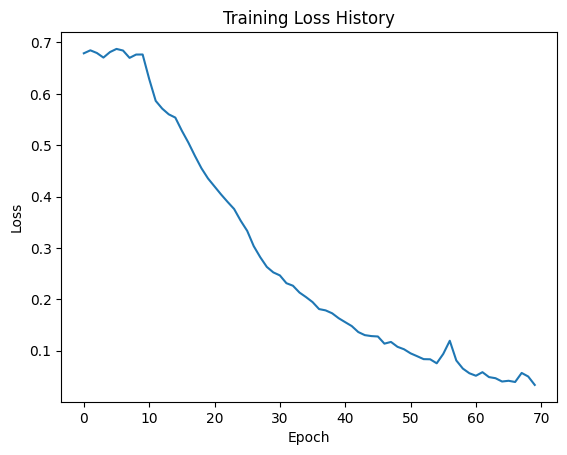

Final Training Loss: 0.0332


In [21]:
summary_model = SummaryNetwork(fixed_embed=True, embedding_dim=2, hidden_size=128, num_layers=2, summary_dim=32, device=device)
query_model = QueryNetwork(summary_dim=32, embedding_layer=summary_model.embedding, device=device)
summary_model, query_model, loss_history = train_summary_query_model(summary_model, query_model, train_loader, num_epochs=70, lr=0.001, plot=True, device=device)

print(f'Final Training Loss: {loss_history[-1]:.4f}')

In [22]:
acc = test_summary_query_model(summary_model, query_model, test_loader, device=device)
print(f'Test Accuracy: {acc * 100:.2f}%')

Test Accuracy: 98.86%


### Networks with Trained Embeddings

Epoch 1/90, Loss: 0.6818
Epoch 6/90, Loss: 0.6843
Epoch 11/90, Loss: 0.6850
Epoch 16/90, Loss: 0.5502
Epoch 21/90, Loss: 0.5375
Epoch 26/90, Loss: 0.5283
Epoch 31/90, Loss: 0.4177
Epoch 36/90, Loss: 0.3668
Epoch 41/90, Loss: 0.3561
Epoch 46/90, Loss: 0.3594
Epoch 51/90, Loss: 0.3510
Epoch 56/90, Loss: 0.3503
Epoch 61/90, Loss: 0.3476
Epoch 66/90, Loss: 0.3518
Epoch 71/90, Loss: 0.3449
Epoch 76/90, Loss: 0.3495
Epoch 81/90, Loss: 0.3453
Epoch 86/90, Loss: 0.3468
Epoch 90/90, Loss: 0.3475


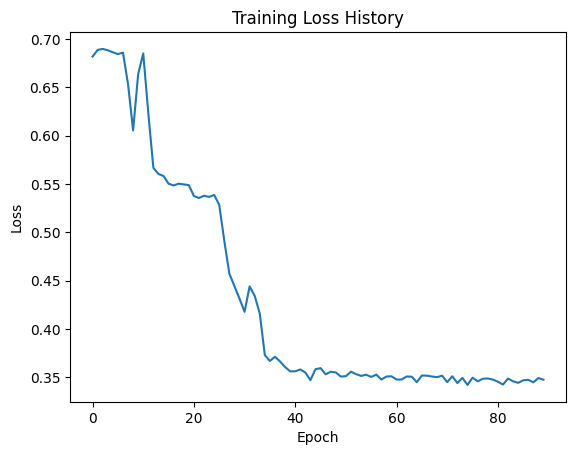

Final Training Loss: 0.3475


In [26]:
te_summary_model = SummaryNetwork(fixed_embed=False, embedding_dim=2, hidden_size=128, num_layers=2, summary_dim=32, device=device)
te_query_model = QueryNetwork(summary_dim=32, embedding_layer=te_summary_model.embedding, device=device)
te_summary_model, te_query_model, te_loss_history = train_summary_query_model(te_summary_model, te_query_model, train_loader, num_epochs=90, lr=0.001, plot=True, device=device)

print(f'Final Training Loss: {te_loss_history[-1]:.4f}')

In [24]:
te_acc = test_summary_query_model(te_summary_model, te_query_model, test_loader, device=device)
print(f'Test Accuracy: {te_acc * 100:.2f}%')

Test Accuracy: 89.16%


### Networks with Training Embeddings Simultaneously

Training simultaneously...
Epoch 1/40, Loss: 0.6884
Epoch 6/40, Loss: 0.6831
Epoch 11/40, Loss: 0.5727
Epoch 16/40, Loss: 0.5237
Epoch 21/40, Loss: 0.3636
Epoch 26/40, Loss: 0.3466
Epoch 31/40, Loss: 0.3385
Epoch 36/40, Loss: 0.3402
Epoch 40/40, Loss: 0.3326


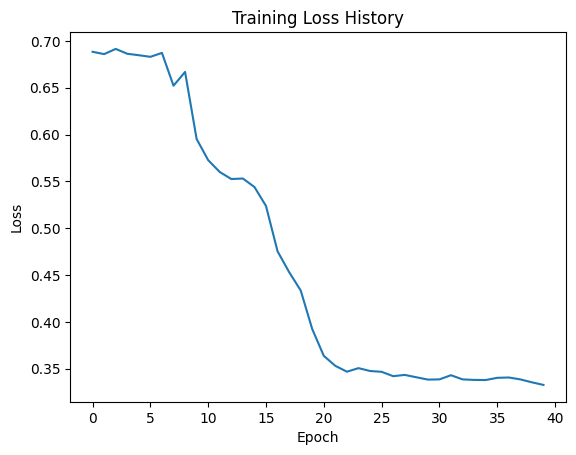

Simultaneous Training Test Accuracy: 84.54%


In [27]:
# Initialize with trainable embeddings
sim_summary_model = SummaryNetwork(fixed_embed=False, embedding_dim=2, hidden_size=128, num_layers=2, summary_dim=32, device=device)
sim_query_model = QueryNetwork(summary_dim=32, embedding_layer=sim_summary_model.embedding, device=device)

print('Training simultaneously...')
sim_summary_model, sim_query_model, sim_loss_history = train_summary_query_model(sim_summary_model, sim_query_model, train_loader, num_epochs=40, lr=0.001, plot=True, device=device)

sim_acc = test_summary_query_model(sim_summary_model, sim_query_model, test_loader, device=device)
print(f'Simultaneous Training Test Accuracy: {sim_acc * 100:.2f}%')

### Networks with Training Embeddings Sequentially

Training with Fixed Embeddings...


/usr/local/lib/python3.12/dist-packages/torch/_compile.py:53: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return disable_fn(*args, **kwargs)


Epoch 1/20, Loss: 0.6870
Epoch 6/20, Loss: 0.6839
Epoch 11/20, Loss: 0.6812
Epoch 16/20, Loss: 0.5604
Epoch 20/20, Loss: 0.5398
Unfreezing Embeddings and Fine-tuning...
Epoch 1/20, Loss: 0.5458
Epoch 6/20, Loss: 0.4887
Epoch 11/20, Loss: 0.3681
Epoch 16/20, Loss: 0.2804
Epoch 20/20, Loss: 0.2289


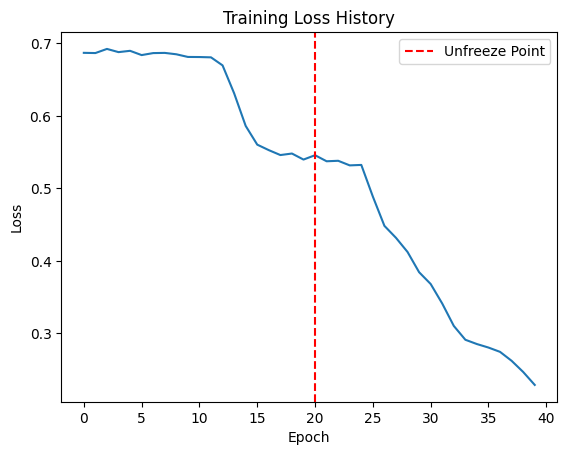

Sequential Training Test Accuracy: 90.34%


In [28]:
# Initialize with frozen embeddings
seq_summary_model = SummaryNetwork(fixed_embed=True, embedding_dim=2, hidden_size=128, num_layers=2, summary_dim=32, device=device)
seq_query_model = QueryNetwork(summary_dim=32, embedding_layer=seq_summary_model.embedding, device=device)

total_epochs = 40

# Train network weights only
print("Training with Fixed Embeddings...")
seq_summary_model, seq_query_model, loss_hist1 = train_summary_query_model(seq_summary_model, seq_query_model, train_loader, num_epochs=total_epochs//2, lr=0.001, plot=False, device=device)

# 3. Phase 2: Unfreeze embeddings
print("Unfreezing Embeddings and Fine-tuning...")
seq_summary_model.embedding.weight.requires_grad = True

# Train again (train_summary_query_model creates a new optimizer, so it will pick up the unfrozen weights)
seq_summary_model, seq_query_model, loss_hist2 = train_summary_query_model(seq_summary_model, seq_query_model, train_loader, num_epochs=total_epochs//2, lr=0.001, plot=False, device=device)

# Combine history and plot
total_history = loss_hist1 + loss_hist2
plt.plot(total_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.axvline(x=total_epochs//2, color='r', linestyle='--', label='Unfreeze Point')
plt.legend()
plt.show()

seq_acc = test_summary_query_model(seq_summary_model, seq_query_model, test_loader, device=device)
print(f'Sequential Training Test Accuracy: {seq_acc * 100:.2f}%')

## Adjacent Queries Networks

### Adjacent Dataset

In [13]:
class AdjacentQueryDataset(Dataset):
    def __init__(self, num_sequences):
        self.num_sequences = num_sequences
        self.device = device

    def __len__(self):
        return self.num_sequences
    
    def __getitem__(self, idx):
        # q must be 0-8 so q+1 is a valid digit (0-9)
        q = random.randint(0, 8)
        
        # 50/50 split for labels
        label = 1 if random.random() < 0.5 else 0
        
        length = random.randint(10, 50)
        seq = [random.randint(0, 9) for _ in range(length)]
        
        # Check if [q, q+1] exists
        def has_adjacency(s, val):
            for i in range(len(s)-1):
                if s[i] == val and s[i+1] == val+1:
                    return True
            return False

        present = has_adjacency(seq, q)
        
        if label == 1:
            if not present:
                # Insert [q, q+1] at random position
                insert_idx = random.randint(0, len(seq))
                seq.insert(insert_idx, q)
                seq.insert(insert_idx+1, q+1)
        else:
            # Remove any occurrences of [q, q+1]
            while has_adjacency(seq, q):
                for i in range(len(seq)-1):
                    if seq[i] == q and seq[i+1] == q+1:
                        # Remove the second element to break the pair
                        seq.pop(i+1)
                        break
        
        return seq, q, label

In [14]:
adj_train_dataset = AdjacentQueryDataset(50000)
adj_test_dataset = AdjacentQueryDataset(5000)

adj_train_loader = DataLoader(adj_train_dataset, batch_size=128, shuffle=True, collate_fn=collate_padding)
adj_test_loader = DataLoader(adj_test_dataset, batch_size=128, shuffle=False, collate_fn=collate_padding)

### Test Adjacent Networks

Epoch 1/90, Loss: 0.6924
Epoch 6/90, Loss: 0.6886
Epoch 11/90, Loss: 0.5945
Epoch 16/90, Loss: 0.5304
Epoch 21/90, Loss: 0.3982
Epoch 26/90, Loss: 0.3140
Epoch 31/90, Loss: 0.2969
Epoch 36/90, Loss: 0.2385
Epoch 41/90, Loss: 0.0534
Epoch 46/90, Loss: 0.0245
Epoch 51/90, Loss: 0.0288
Epoch 56/90, Loss: 0.0020
Epoch 61/90, Loss: 0.0014
Epoch 66/90, Loss: 0.0007
Epoch 71/90, Loss: 0.0054
Epoch 76/90, Loss: 0.0004
Epoch 81/90, Loss: 0.0053
Epoch 86/90, Loss: 0.0002
Epoch 90/90, Loss: 0.0002


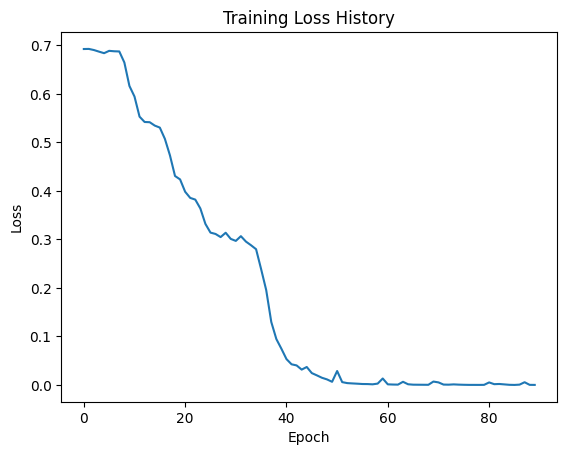

Adjacency Task Test Accuracy: 100.00%


In [24]:
adj_summary_model = SummaryNetwork(fixed_embed=False, embedding_dim=2, hidden_size=128, num_layers=2, summary_dim=32, bider=True, device=device)
adj_query_model = QueryNetwork(summary_dim=32, embedding_layer=adj_summary_model.embedding, device=device)
adj_summary_model, adj_query_model, adj_loss_history = train_summary_query_model(adj_summary_model, adj_query_model, adj_train_loader, num_epochs=90, lr=0.001, plot=True, device=device)

adj_acc = test_summary_query_model(adj_summary_model, adj_query_model, adj_test_loader, device=device)
print(f'Adjacency Task Test Accuracy: {adj_acc * 100:.2f}%')

### Comparing Embeddings

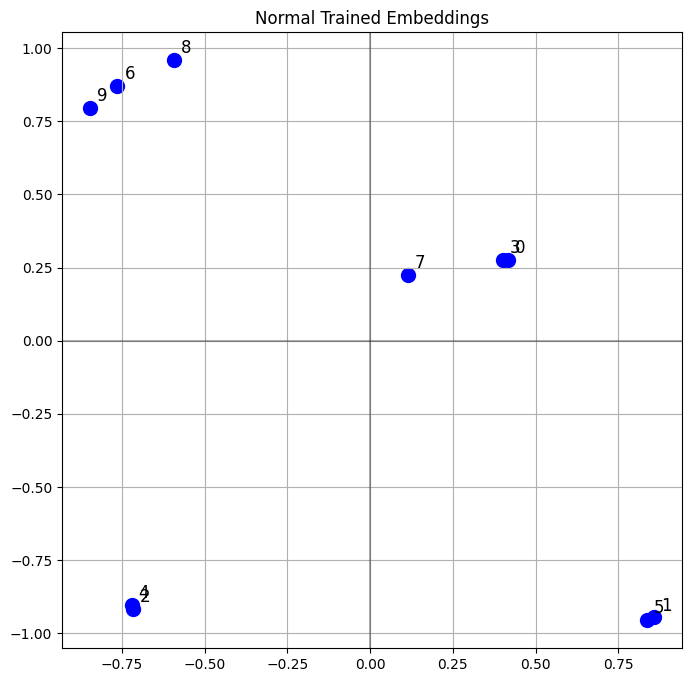

In [34]:
plot_embeddings(sim_summary_model, title="Normal Trained Embeddings")

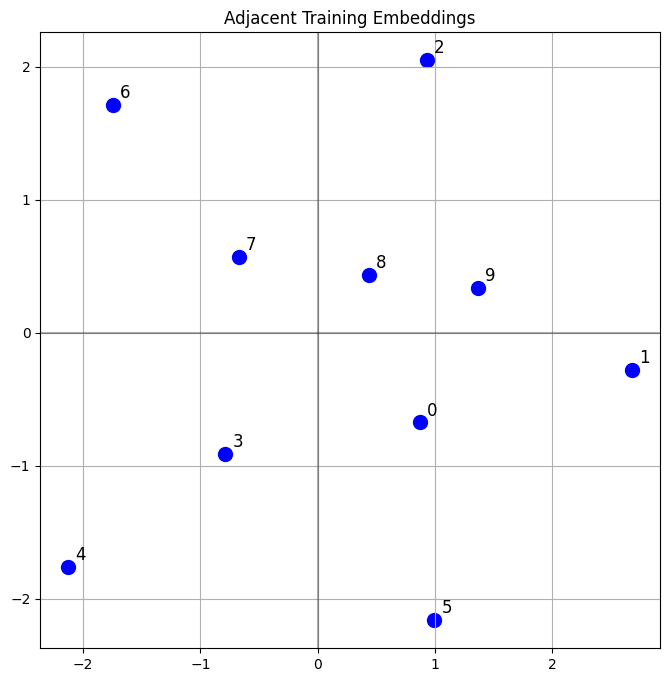

In [25]:
plot_embeddings(adj_summary_model, title="Adjacent Training Embeddings")

Trying new thing

In [26]:
class SummaryNetwork2(nn.Module):
    def __init__(self, fixed_embed=True, embedding_dim=2, hidden_size=32, num_layers=1, summary_dim=32, bider=False, device='cpu'):
        super().__init__()

        # Digits 0-9 plus padding token -> 10 as padding token
        self.padding_idx = PADDING_TOKEN

        # Trainable or fixed embedding
        self.embedding = nn.Embedding(
            num_embeddings=11,              # 0-9 plus padding token 10
            embedding_dim=embedding_dim,    # assignment says 2D embedding
            padding_idx=self.padding_idx
        )

        # Always initialize embedding with uniform random
        with torch.no_grad():
            self.embedding.weight[:-1].uniform_(-1.0, 1.0)
            self.embedding.weight[-1].zero_()     # padding -> zero vector

        # Freeze embedding if fixed_embed=True
        if fixed_embed:
            self.embedding.weight.requires_grad = False

        # LSTM receives sequences of embedding_dim
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bider)

        # The summary vector is a fixed-dimension vector: last hidden state -> summary_dim
        fc_input_dim = hidden_size * 2 if bider else hidden_size
        self.fc = nn.Linear(fc_input_dim, summary_dim)

        self.to(device)

    def forward(self, x, lengths):
        # Convert token indices -> embeddings
        x = self.embedding(x) # (B, L, embedding_dim)

        # Pack to ignore padding steps
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)

        # Pass through LSTM
        packed_out, (h_n, c_n) = self.lstm(packed)

        if self.lstm.bidirectional:
            # h_n shape: (num_layers*2, batch, hidden_size)
            # We want the last two indices (forward and backward of the top layer)
            
            # Take the last layer's forward (index -2) and backward (index -1)
            hidden_fwd = h_n[-2, :, :]
            hidden_bwd = h_n[-1, :, :]
            
            # Concatenate them -> (batch, hidden_size * 2)
            last_hidden = torch.cat((hidden_fwd, hidden_bwd), dim=1)
        else:
            last_hidden = h_n[-1]


In [ ]:
adj_summary_model2 = SummaryNetwork2(fixed_embed=False, embedding_dim=2, hidden_size=128, num_layers=2, summary_dim=32, bider=True, device=device)
adj_query_model2 = QueryNetwork(summary_dim=32, embedding_layer=adj_summary_model2.embedding, device=device)
adj_summary_model2, adj_query_model2, adj_loss_history2 = train_summary_query_model(adj_summary_model2, adj_query_model2, adj_train_loader, num_epochs=90, lr=0.001, plot=True, device=device)

adj_acc2 = test_summary_query_model(adj_summary_model2, adj_query_model2, adj_test_loader, device=device)
print(f'Adjacency Task Test Accuracy: {adj_acc2 * 100:.2f}%')

/usr/local/lib/python3.12/dist-packages/torch/_compile.py:53: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return disable_fn(*args, **kwargs)


TypeError: expected Tensor as element 0 in argument 0, but got NoneType